## Բառերի տարբերակման մոդելի ուսուցում
Այս նոթբուքում կստեղծենք և կուսուցանենք մեր մոդելը որը կտարբերակի բոլոր այն բառերի արտասանությունը որոնք կլինեն մեր "data" տվյալների բազայում։
<br><br>
Աշխատանքի հերթականությունը հետեվյալն է․
Նախ կներբեռնենք մեր ձայնագրությունները, կվերամշակենք ապա կբաժանենք թեստավորման և ուսուցման։
<br><br>
Մեր ձայնագրությունների սպեկտոգռամաից կստանանք ձայնի հզորության սպեկտոգրամաներ։
Ստացված սպեկտոգռամաները կլինեն մեր մոդելի մուտքային տվյալները։ 
<br><br>
Իսկ մեր մոդելը պարզագույն "Image classification"-ի խնդիր է լուծում։
<br><br>
Վերջում ստացված մոդելը կարող ենք փորձարկել իրական ժամանակում (այսինքն ձայնագրեք ձեր բառը և անմիջապես ստացեք պատասխանը)։
Եվ իհարկե կպահպանենք մեր մոդելը "saved" բաժնում։
<br><br>
Նախքան աշխատանքը սկսելը համոզված եղեք որ ներբեռնել եք բոլոր այս գրադարանները > <br>
#pathlib
#matplotlib
#numpy
#seaborn
#tensorflow
#scipy
#soundfile
#IPython
#sounddevice

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

ԻՆտեգրում ենք "Google Drive"-ը որտեղից կստանանք մեր տվյալները։<br>
Իսկ հետո ներբեռնում ենք մեզ անհրաժեշտ գրադարանները։

In [2]:
!pip install seaborn
!pip install tf-nightly


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\sakoy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\sakoy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from random import sample
from scipy.io import wavfile
import soundfile
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Այստեղ հայտարարում ենք այդ գրադարանները և ֆիքսում մեր randomizer-ը։

In [4]:
DATASET_PATH = 'data/mini_speech_commands/all'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

Այս բլոկում վերցնում ենք մեր տվյալները։ Եթե դրանք բացակայում են հոգ չէ, ծրագիրը անմիջապես կներբեռնի ցանցից։

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'noise' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three'
 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


Այստեղ տեսնում ենք մեր ձայնագրությունների label-ները։ Այստեղ նշված բոլոր բաժիններում կան իր բաժնին վերաբերվող ձայնագրություններ։

(array([    0.,     0.,     0.,     0.,     0., 94535.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

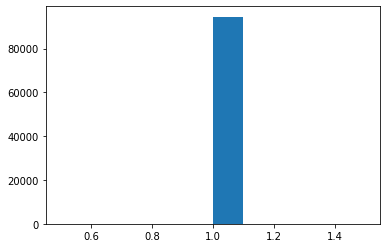

In [6]:
duration_of_recordings=[]
for label in commands:
    waves = [f for f in os.listdir(DATASET_PATH + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        PATH = DATASET_PATH + '/' + label + '/' + wav
        sample_rate, samples = wavfile.read(PATH)
        soundfile.write(PATH, samples, sample_rate, subtype='PCM_16')

        temp = float(len(samples)/sample_rate)
        duration_of_recordings.append(temp)
        if (temp != 1):
            file_to_rem = pathlib.Path(DATASET_PATH + '/'+ label + '/' + wav).unlink()
plt.hist(np.array(duration_of_recordings))

Այս բլոկու ջնջեցինք բոլոր ձայնագրությունները որոնց տևողությունը տարբերվում է 1 վայրկյանից։

In [7]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.1,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print("label names:", label_names)

Found 94535 files belonging to 36 classes.
Using 85082 files for training.
Using 9453 files for validation.
label names: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'noise' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three'
 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


Տպեցինք ընդհանուր տվյալների քանակությունը

In [8]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Աուդիոտվյալները մշակում ենք և դարձնում մեզ հարմար, իսկ հաջորդ բլոկում տպում ենք դրանք

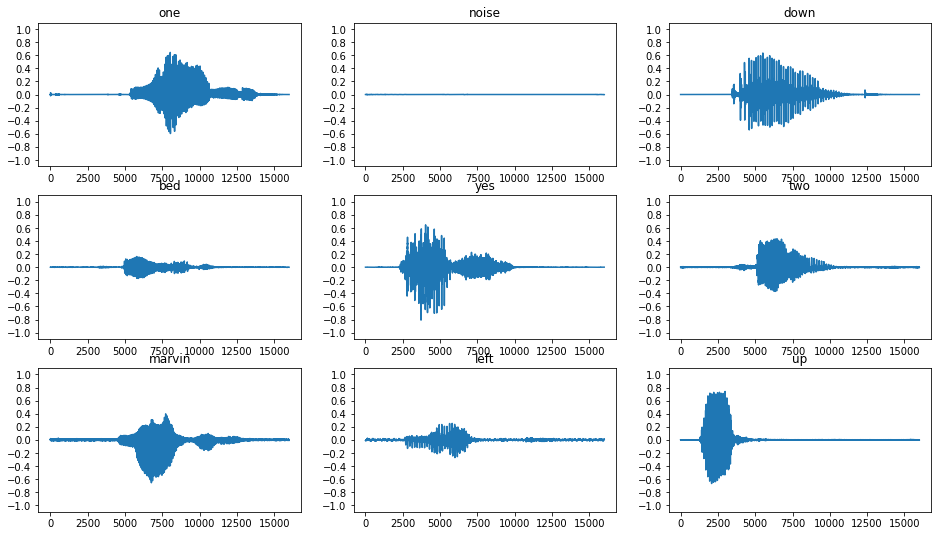

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(example_audio[i].numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label_names[example_labels[i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [12]:
# from MFCCs.stft import stft

def get_spectrogram(waveform):
  
  # Convert the waveform to a spectrogram via a STFT.
  # coefs, spec = mfcc(y=waveform, sr=16000, fft_size=256)
  # spec = stft(xn=waveform, hopsize= 128, fft_size = 256)
  spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128)

  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # spec = tf.abs(spec)

  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  # spec = spec[..., tf.newaxis]
  return spectrogram

Այստեղ ստանում ենք մեր սպեկտոգրաման ձայնային ալիքից։<br>
Խորհուրդ է տրվում ուսումնասիրել "sort time furie transform" ալգորիթմը որը օգտագործել ենք այստեղ։

In [13]:
for i in range(2):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

(124, 256) tf.Tensor(256, shape=(), dtype=int32)
Label: one
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


(124, 256) tf.Tensor(256, shape=(), dtype=int32)
Label: noise
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Լսենք մի քանի օրինակ

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Այս ֆունկցիան տպում է սպեկտոգրաման արդեն հզորությայ փոփոխած։ Այսինքն հաջորդ պատկերում կտեսնեք ձայնի ձայնագրության հզորությունները որը մենք կոգտագործենք մոդելը սովորեցնելու մեջ։

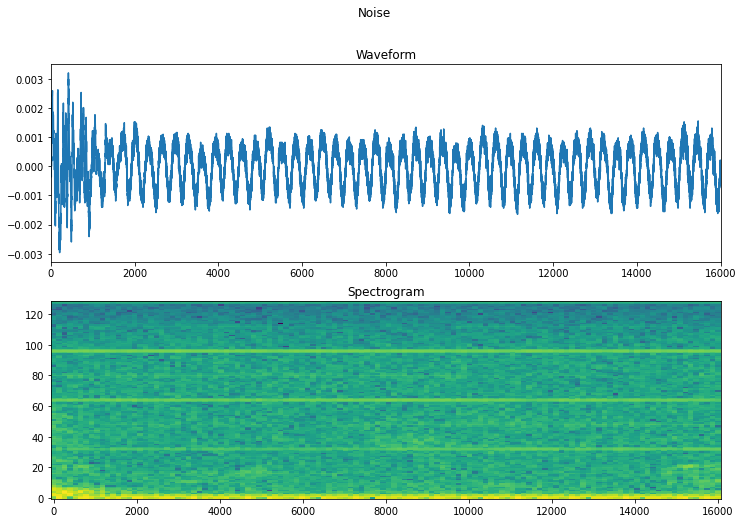

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [16]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
train = train_spectrogram_ds.take(1)
for i in train:
    print(i[0].shape)

(None, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)
(None, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)
(None, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)
(64, 124, 129, 1)


Կատարում ենք նույն գործողությունները մնացած տվյալների վրա և տպում դրանցից մի քանիսը

In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

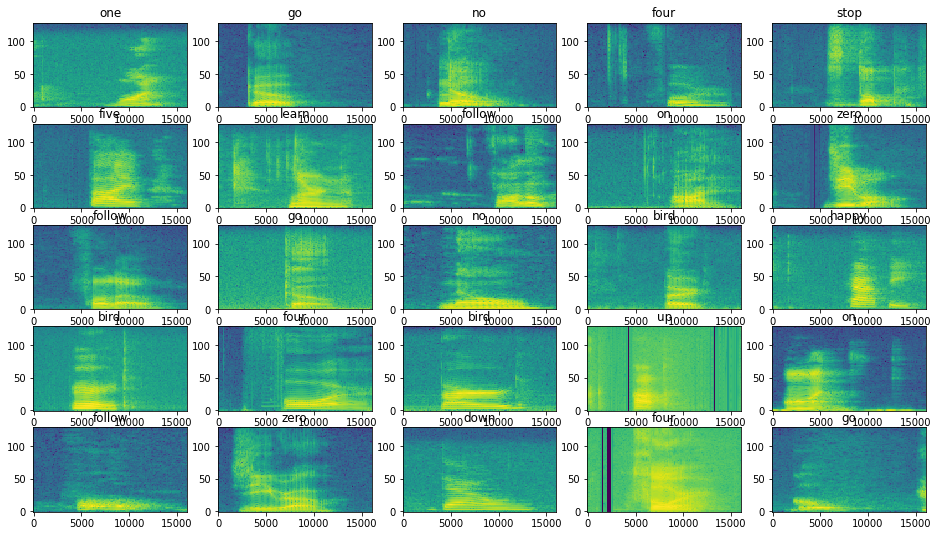

In [19]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(100).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [21]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Այստեղ ներկայացված է մոդելը։ Այն "Convolutional" մոդել է որը իր մեջ պարունակում է նոռմալիզացիայի մի քանի մեթոդ։ Այս բոլոր շերտերը ուսումնասիրելը պարտադիր է հասկանալու համար թէ ինչպես է մոդելը աշխատում․ այնպես որ ուսումնասիրեք բոլորը

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Նաև նշում ենք մոդելի օպտիմիզացիաի տեսակը և ճշտությունը հաշվելու մեթոդը։ Իսկ հաջորդ բլոկում արդեն սկսվում է ուսուցման պրոցեսը։

In [23]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
1330/1330 [==============================] - 114s 85ms/step - loss: 1.9028 - accuracy: 0.4567 - val_loss: 0.9324 - val_accuracy: 0.7433
Epoch 2/50
1330/1330 [==============================] - 105s 79ms/step - loss: 1.1305 - accuracy: 0.6640 - val_loss: 0.6941 - val_accuracy: 0.8026
Epoch 3/50
1330/1330 [==============================] - 105s 79ms/step - loss: 0.9429 - accuracy: 0.7157 - val_loss: 0.6024 - val_accuracy: 0.8194
Epoch 4/50
1330/1330 [==============================] - 105s 79ms/step - loss: 0.8430 - accuracy: 0.7441 - val_loss: 0.5458 - val_accuracy: 0.8444
Epoch 5/50
1330/1330 [==============================] - 104s 78ms/step - loss: 0.7658 - accuracy: 0.7655 - val_loss: 0.5242 - val_accuracy: 0.8435
Epoch 6/50
1330/1330 [==============================] - 104s 78ms/step - loss: 0.7136 - accuracy: 0.7804 - val_loss: 0.4924 - val_accuracy: 0.8556
Epoch 7/50
1330/1330 [==============================] - 102s 77ms/step - loss: 0.6636 - accuracy: 0.7953 - val_loss: 0

Text(0, 0.5, 'Accuracy [%]')

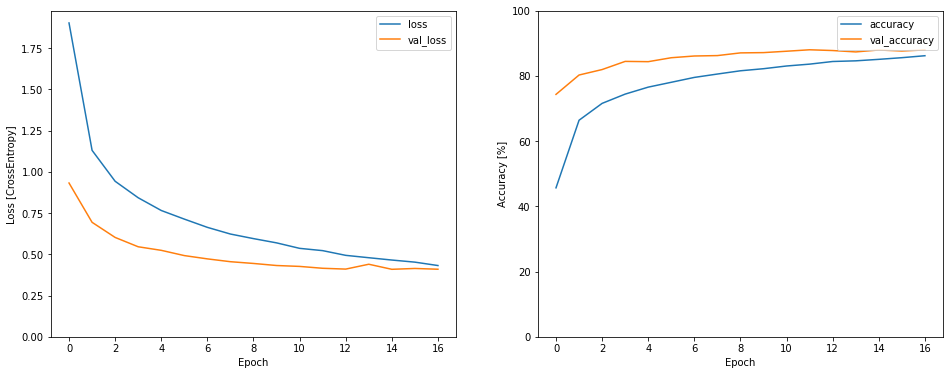

In [24]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


Ի վերջո տեսնում ենք մեր մոդելի ճշտությունը։ Կարող եք ինքներդ փորձել լավարկել այս ճշտությունը։

In [25]:
model.evaluate(test_spectrogram_ds, return_dict=True)

74/74 [==============================] - 2s 31ms/step - loss: 0.4322 - accuracy: 0.8820


{'loss': 0.4322426915168762, 'accuracy': 0.8819679021835327}

In [26]:
y_pred = model.predict(test_spectrogram_ds)

74/74 [==============================] - 1s 14ms/step


In [27]:
y_pred = tf.argmax(y_pred, axis=1)

In [28]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

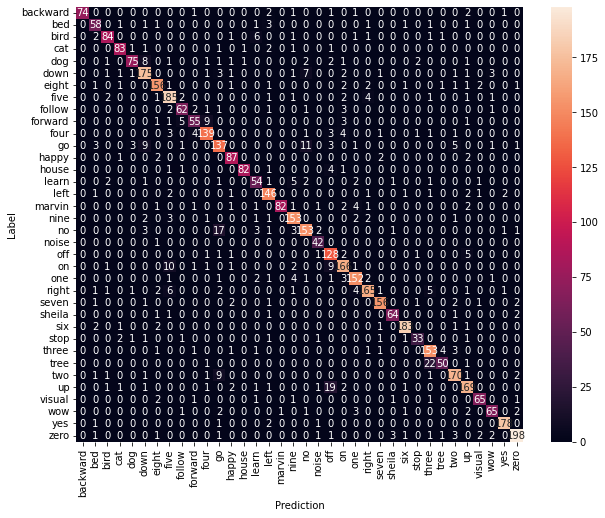

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [30]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Այս բլոկում ստեղծում ենք օբյեկտ որը պետք է պահպանի մեր մոդելը։ Իսկ հաջորդ բլոկում այն կատարում է պահպանման գործողությունը։

In [31]:
export = ExportModel(model)
tf.saved_model.save(export, "saved")

(1, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)
(None, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)
(1, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)
(None, 124, 256) Tensor("stft/Const:0", shape=(), dtype=int32)


INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


In [32]:
import tensorflow as tf

imported = tf.saved_model.load("saved")
# imported(tf.constant(str(data_dir/'random/audio_50.wav')))['predictions']
# model.save('new_mirai.h5')
imported

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x24c7862f790>

Այստեղ վերցնում ենք մեր պահպանված մոդելը և փորձարկում այն հաջորդ բլոկում։

In [33]:
import sounddevice as sd
samplerate = 16000
# words = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow',
#  'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no',
#  'noise', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
#  'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
while True:
    recording = sd.rec(int(1*samplerate),samplerate = samplerate , channels = 1, dtype='float32').ravel()
    sd.wait()
    recording = recording[tf.newaxis, :]
    str = imported(recording)['class_names'][0]
    print(str)
    # waveform = recording
    # recording = get_spectrogram(recording)
    # recording = recording[tf.newaxis,...]

    # prediction = model(recording)
    # pred = tf.nn.softmax(prediction[0])
    # pred = tf.math.argmax(pred,0)
    # print(commands[pred])

tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dtype=string)
tf.Tensor(b'noise', shape=(), dt

KeyboardInterrupt: 